Simulated Annealing algorithm applied to Eggholder Function

In [688]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Set the random number generator seed
np.random.seed(0)

Define constants

In [920]:
LIM = 512 # Constraint of problem
DIM = 2 # Number of dimensions in problem

FUNC_EVAL_LIM = 15000

INITIAL_T_PROB = 0.8  # Initial probability that solution should be accepted
T_EST_SAMPLES = 100  # Number of samples to use to find initial T

UPDATE_RULE = 'Parks' # 'Simple', 'Parks'
MAX_CHANGE = 512  # Maximum change of variable in single step

L_K = 150  # Markov chain length
ETA_MIN = 0.6  # Acceptance proportion of chain to finish anneal
ACCEPTANCE_BREAKOUT = 0.001  # Threshold for solution acceptance ratio

ANNEALING_TYPE = 'Huang'   # 'Kirkpatrick', 'Huang'
ALPHA = 0.95  # Kirkpatrick et al. [1982] Exponential cooling

## Constants for Parks step update rule
ALPHA_PARKS = 0.1
OMEGA_PARKS = 2.1
D_INIT_MAG = 0.32

RESET_THRESHOLD = 185 #Number of iterations without change in best solution

## Archiving constants
ARCHIVE_LEN = 25 # Length of Archive
DISS_MIN = 50 # Minimum distance away before can be entered into dissimilar Archive
DISS_SIM = 5 # Minimum distance away before can replace closest element from dissimilar Archive

METHOD = 'Simulated Annealing'

In [924]:
## Define eggholder function 
def eggholder(x):
    y = 0
    for i in range(len(x)-1):
        y += -(x[i+1]+47) * math.sin(np.sqrt(abs(x[i+1]+x[i]/2+47))) - x[i] * math.sin(np.sqrt(abs(x[i]-x[i+1]-47)))
    return y 

Functions to enable SA

In [907]:
## Update value of x using simple scheme
def update_x_simple(x):
    C = MAX_CHANGE * np.ones(DIM)
    u = np.random.uniform(-1, 1, DIM)
    dx = C * u 
    x_next = x + dx

    ## No penalty function needed, instead reject all moves that violate constraint
    while (x_next > LIM).any() | (x_next < -LIM).any():
        u = np.random.uniform(-1, 1, DIM)
        dx = C * u 
        x_next = x + dx  
    return x_next

## Update value of x using Parks scheme
def update_x_parks(x, D):
    ## Note x has been scaled so [-1,1]
    u = np.random.uniform(-1, 1, DIM)
    dx = D * u 
    x_next = x + dx
    
    ## No penalty function needed, instead reject all moves that violate constraint
    while (x_next > 1).any() | (x_next < -1).any():
        u = np.random.uniform(-1, 1, DIM)
        dx = D * u
        x_next = x + dx
    return x_next, dx

## Update D as in Parks
def update_D_parks(D, R, alpha = ALPHA_PARKS, omega = OMEGA_PARKS):
    ## As in lecturen notes
    D_new = (1-alpha) * D + alpha * omega * np.abs(R)
    return D_new

def check_accept_solution_simple(df, T):
    ## Metropolis
    if df < 0:
        return True
    else:
        p = np.exp(-df / T)
        if np.random.random() < p:
            return True
        else:
            return False

def check_accept_solution_parks(df, T, R):
    if df < 0:
        return True
    else:
        ## Taking into account effectiveness of change
        d_bar = np.sqrt(np.square(R).sum())
        p = np.exp(-df/(T*d_bar))
        if np.random.random() < p:
            return True
        else:
            return False

def kirkpatrick_anneal(T):
    return T * ALPHA

def huang_anneal(T, f_acc_curr):
    ## As in lecture notes
    if len(f_acc_curr) > 1:
        sigma = np.std(f_acc_curr)
        alpha = max(0.5, np.exp(-(0.7 * T) / sigma))
    else:
        alpha = 0.5
    return T * alpha

###--------------------------------------###
## Functions for archiving

## Calculate Euclidean distance between 2 arrays
def dist(x_new, x_old):
    diss = 0
    for i in range(len(x_new)):
        diss += (x_new[i] - x_old[i])**2
    return np.sqrt(diss)

## Update both best and dissimilar archives
def update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, x, f_curr):
    ## If dissimilar array is len 0, fill 
    if len(diss_archive_x) == 0:
        diss_archive_x.append(x)
        diss_archive_f.append(f_curr)
    ## If array not full, fill if input is dissimilar to everything else
    elif len(diss_archive_x) < ARCHIVE_LEN:
        check_diss = True
        for i in range(len(diss_archive_x)):
            diss = dist(x,diss_archive_x[i])
            if diss < DISS_MIN:
                check_diss = False
        if check_diss:
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
    ## If array is full
    else:
        min = np.inf
        check_diss = True
        for i in range(len(diss_archive_x)):
            diss = dist(x, diss_archive_x[i])
            if diss < DISS_MIN:
                check_diss = False
            ## Get most similar x
            if diss < min:
                min = diss
                x_e_index = i
        ## If dissimilar and solution better than worst
        if check_diss & (f_curr < np.max(diss_archive_f)):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(np.argmax(diss_archive_f))
            diss_archive_f.pop(np.argmax(diss_archive_f))
        ## If solution is best so far
        elif (f_curr < np.min(diss_archive_f)):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(x_e_index)
            diss_archive_f.pop(x_e_index)
        ## Or if solution not best but sufficiently similar and better than x_e
        elif ((min<DISS_SIM) & (f_curr < diss_archive_f[x_e_index])):
            diss_archive_x.append(x)
            diss_archive_f.append(f_curr)
            diss_archive_x.pop(x_e_index)
            diss_archive_f.pop(x_e_index)
        else:
            pass
    
    ## If best array not full, fill 
    if len(best_archive_x) < 25:
        best_archive_x.append(x)
        best_archive_f.append(f_curr)
    ## If array is full
    elif f_curr < np.max(best_archive_f):
        best_archive_x.append(x)
        best_archive_f.append(f_curr)
        best_archive_x.pop(np.argmax(best_archive_f))
        best_archive_f.pop(np.argmax(best_archive_f))
    return diss_archive_x, diss_archive_f, best_archive_x, best_archive_f

In [908]:
def estimate_initial_temperature(num_evals, seed = 0):
    np.random.seed(seed)
    f = eggholder 

    diss_archive_x = []
    diss_archive_f = []
    best_archive_x = []
    best_archive_f = []

    x_best = None
    f_best = np.inf

    ## Initialise x and function value randomly
    x = np.random.uniform(-LIM, LIM, DIM)
    f_curr = f(x)

    x_best = x
    f_best = f_curr

    xs = []; fs = []

    df = [] # Store of all positive difference between function values

    D = D_INIT_MAG * np.ones(DIM)
    
    for i in range(num_evals):
        if UPDATE_RULE == 'Simple':
            x_new = update_x_simple(x)
        else:
            x_new, R = update_x_parks(x/LIM, D)
            x_new *= LIM
        f_new = f(x_new)
        
        # if i > 50:
        #     df.append(f_new - f_curr)
        df.append(f_new - f_curr)

        ## Update x and function value
        x = x_new
        f_curr = f_new

        ## Dissimilar archiving
        diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, x, f_curr)

        if f_curr < f_best:
            if UPDATE_RULE == 'Parks':
                D = update_D_parks(D, R, alpha = ALPHA_PARKS, omega = OMEGA_PARKS)
            x_best = x
            f_best = f_curr
            xs.append(x_best)
            fs.append(f_best)

    df = np.array(df)
    df_mean = df[df>0].mean()
    T0 = - df_mean / np.log(INITIAL_T_PROB)
    if UPDATE_RULE == 'Simple':
        return T0, x_best, f_best, xs, fs, diss_archive_x, diss_archive_f, best_archive_x, best_archive_f
    else:
        return T0, x_best, f_best, D, xs, fs, diss_archive_x, diss_archive_f, best_archive_x, best_archive_f

In [909]:
def search(seed = 0):
    f = eggholder

    ## Initial temprature 
    if UPDATE_RULE == 'Simple':
        T_mean, x_start, f_start, xs, fs, diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = estimate_initial_temperature(T_EST_SAMPLES, seed = seed)
    else:
        T_mean, x_start, f_start, D, xs, fs, diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = estimate_initial_temperature(T_EST_SAMPLES, seed = seed)
    T = T_mean 

    ## Initialise with end value of initial temperature estimation
    x_best = x_start
    f_best = f_start
    evals = T_EST_SAMPLES
    
    ## Define current x and function value
    x = x_best
    f_curr = f_best
    
    l_curr = 0 # length of Markov chain at each temp
    eta_curr = 0 # number of accepted xs at each temp
    acc = 0 # total accepted xs
    evals_since_best = 0 # evalutions since improvement in function
    found_best_curr = False # whether improvement in current evaluation
    f_acc_curr = [] # function values per temp (for Huang annealing)

    xs = []; fs = []
    
    # Arrays to store historical data and to know when new solutino is found (best) or x value accepted (acc)
    x_hist = [] ; f_hist = [] ; T_hist = [] ; acc_hist = [] ; best_hist = [] 

    ## Define path for plotting xs where there is an improvement in function (only for 2D)
    if DIM==2:
        path = {f(x):x.copy()}

    ## While iterations below max iterations allowed
    while evals < FUNC_EVAL_LIM:
        # if evals % 500 == 0:
        #     print('Iterations:{}'.format(evals))
        ## Annealing schedule definition
        if eta_curr > (L_K * ETA_MIN) or l_curr > L_K:

            ## Annealing logic
            if ANNEALING_TYPE == 'Kirkpatrick':
                T = kirkpatrick_anneal(T)
            elif ANNEALING_TYPE == 'Huang':
                T = huang_anneal(T, f_acc_curr)
            else:
                raise ValueError('Please select a valid Annealing method')

            l_curr = 0
            eta_curr = 0
            f_acc_curr = []

            ## Stopping criterion - no improvement and solution acceptance ratio falling below certain value
            if not found_best_curr and acc/evals < ACCEPTANCE_BREAKOUT:
                print('Stopping criterion reached at iteration: {}'.format(evals))
                break

        ## Update x and function value
        if UPDATE_RULE == 'Simple':
            x_next = update_x_simple(x)
        else: # If Parks
            x_next, R = update_x_parks(x/LIM, D) # Scale so control variable [-1,1]
            x_next *= LIM
        f_next = f(x_next)

        evals += 1
        l_curr += 1

        x_hist.append(x_next) ; f_hist.append(f_next) ; T_hist.append(T) # Records past values of x, f, and T

        ## Metropolis  
        if UPDATE_RULE == 'Simple':
            if check_accept_solution_simple(f_next - f_curr, T):
                x = x_next
                f_curr = f_next

                eta_curr += 1
                acc += 1
                acc_hist.append(1)
                f_acc_curr.append(f_curr)

                ## Archiving
                diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, x, f_curr)

                ## If improvement in function
                if f_next < f_best:
                    x_best = x
                    f_best = f_curr
                    best_hist.append(1)
                    found_best_curr = True
                    evals_since_best = 0
                    xs.append(x_best)
                    fs.append(f_best)
                    if DIM==2:
                        path[f(x)] = x.copy()
                else:
                    found_best_curr = False
                    best_hist.append(0)
                    evals_since_best += 1

                ## Reset logic 
                if evals_since_best > RESET_THRESHOLD:
                    x = x_best
                    f_curr = f_best

                    eta_curr = 0
                    l_curr = 0
                    
                    evals_since_best = 0
                    found_best_curr = False
                    # print(f'reset at {evals}')

            else:
                acc_hist.append(0)
                best_hist.append(0)
        else: # If Parks
            if check_accept_solution_parks(f_next - f_curr, T, R):
                x = x_next
                f_curr = f_next

                eta_curr += 1
                acc += 1
                acc_hist.append(1)
                f_acc_curr.append(f_curr)
                
                ## Archiving
                diss_archive_x, diss_archive_f, best_archive_x, best_archive_f = update_archive(diss_archive_x, diss_archive_f, best_archive_x, best_archive_f, x, f_curr)
                
                ## If improvement in function
                if f_next < f_best:
                    x_best = x
                    f_best = f_curr
                    best_hist.append(1)
                    found_best_curr = True
                    evals_since_best = 0
                    xs.append(x_best)
                    fs.append(f_best)

                    D = update_D_parks(D, R, alpha = ALPHA_PARKS, omega = OMEGA_PARKS)
                    
                    if DIM==2:
                        path[f(x)] = x.copy()
                else:
                    found_best_curr = False
                    best_hist.append(0)
                    evals_since_best += 1

                ## Reset logic 
                if evals_since_best > RESET_THRESHOLD:
                    x = x_best
                    f_curr = f_best

                    eta_curr = 0
                    l_curr = 0
                    
                    evals_since_best = 0
                    found_best_curr = False
                    # print(f'reset at {evals}')
            else:
                acc_hist.append(0)
                best_hist.append(0) 

    if DIM == 2:
        return x_best, f_best, np.array(x_hist), np.array(f_hist), np.array(T_hist), np.array(acc_hist), np.array(best_hist), path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, xs, fs
    else:
        return x_best, f_best, np.array(x_hist), np.array(f_hist), np.array(T_hist), np.array(acc_hist), np.array(best_hist), best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, xs, fs

In [921]:
# %%timeit
if DIM == 2:
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = 11)
else:
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search()

In [922]:
for element in x_best:
        assert abs(element) <= 512
x_best, eggholder(x_best)

(array([511.27506426, 403.81143166]), -957.0407853391331)

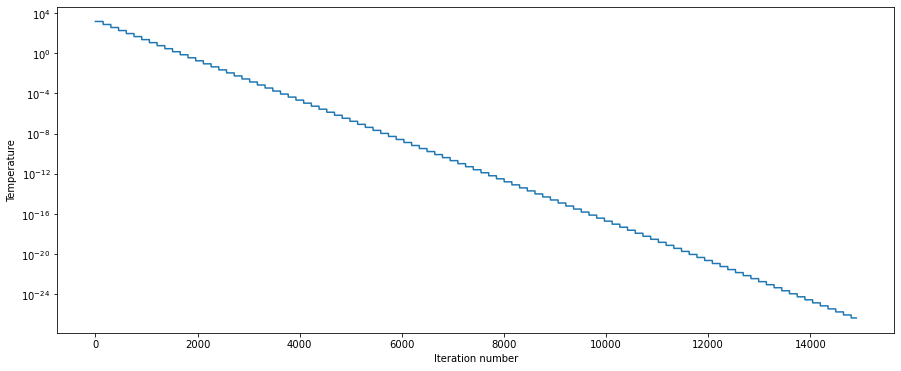

In [923]:
plt.figure(figsize = (15,6))
plt.plot(T_hist, '-')
# plt.title('Objective Function f(x) for new solutions')
plt.ylabel('Temperature');plt.xlabel('Iteration number')
plt.yscale('log')
plt.show()

In [585]:
min = np.inf
count = 0
for i in range(10):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    if eggholder(x_best) < min:
        min = eggholder(x_best)
        if eggholder(x_best) < -959:
            count += 1
min, count

(-959.4786608748113, 2)

In [903]:
def calcEval(num=4000):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    f_eval = np.zeros([len(xx1), len(xx2)])
    
    for i in range(len(x1)):
        for j in range(len(x2)):
            f_eval[i][j] = eggholder([x1[i], x2[j]])
    return f_eval, num
    
def plot_walk(f_eval, points, num, colour = 'C0'):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    fig, ax = plt.subplots(constrained_layout=True)
    CS = ax.contourf(xx1, xx2, f_eval, 20, cmap=cm.plasma)

    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)

    cbar = fig.colorbar(CS)
    cbar.ax.set_ylabel('$f(\mathbf{x})$')
    
    ax.plot(np.array(points)[:,0], np.array(points)[:,1], c=colour)
    plt.show()
    pass

def plot_points(f_eval, points, num, diss_archive_f):
    x1 = np.linspace(-LIM-1, LIM+1, num)
    x2 = np.linspace(-LIM-1, LIM+1, num)
    xx1, xx2 = np.meshgrid(x1, x2)

    fig, ax = plt.subplots(constrained_layout=True)
    CS = ax.contourf(xx1, xx2, f_eval, 20, cmap=cm.plasma)

    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)

    cbar = fig.colorbar(CS)
    cbar.ax.set_ylabel('$f(\mathbf{x})$')

    ax.scatter(np.array(points)[:,0], np.array(points)[:,1], linewidths = 2.5, marker = 'x', c = 'C0')
    plt.show()
    pass

In [854]:
f_eval1, num = calcEval()

In [886]:
num =4000

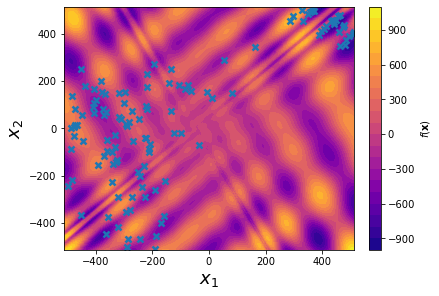

In [887]:
acc_hist = acc_hist == 1
plot_points(f_eval1, x_hist[acc_hist], num, diss_archive_f)

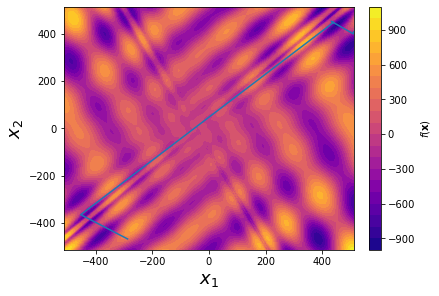

In [888]:
plot_walk(f_eval1, x_sol, num)

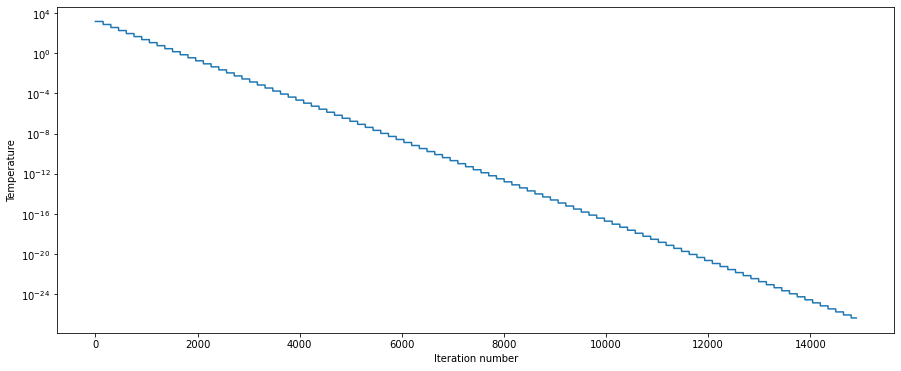

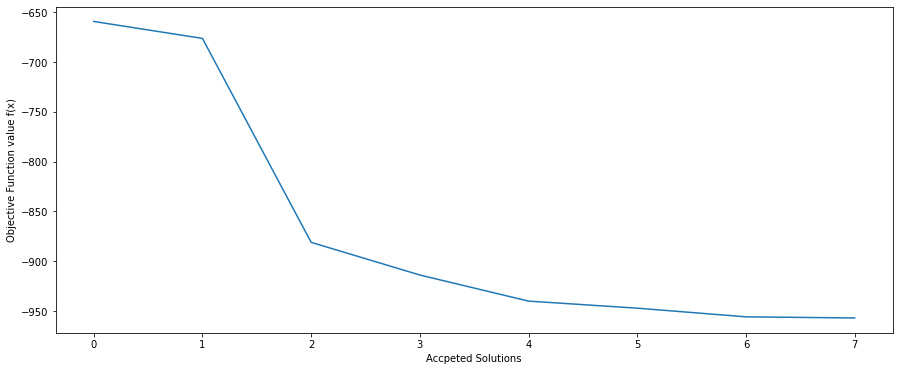

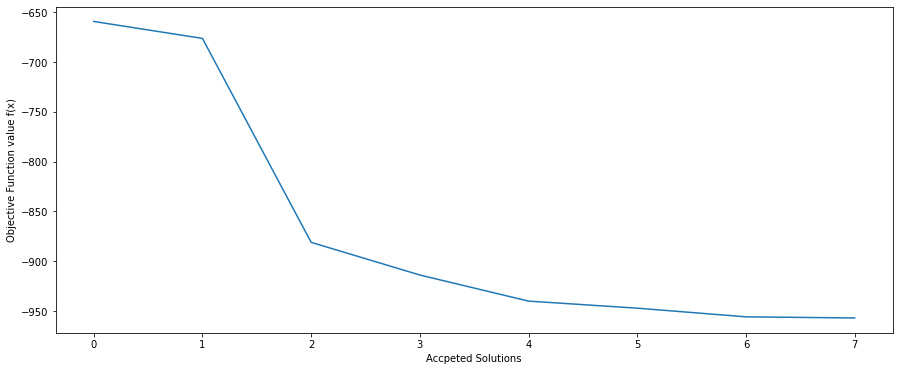

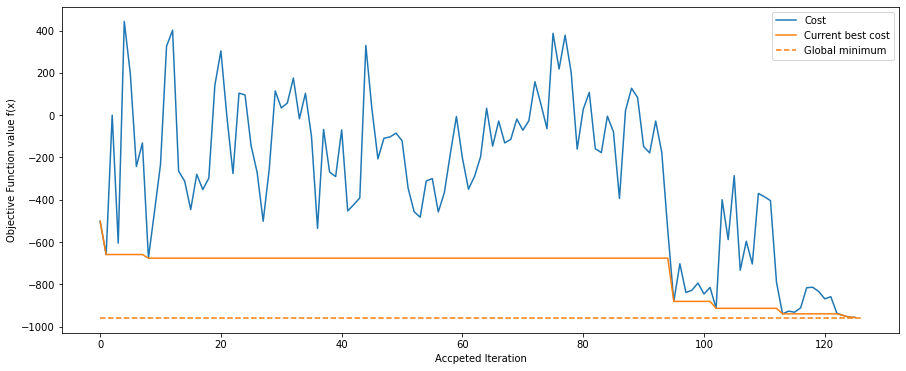

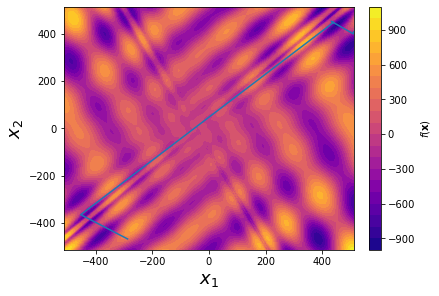

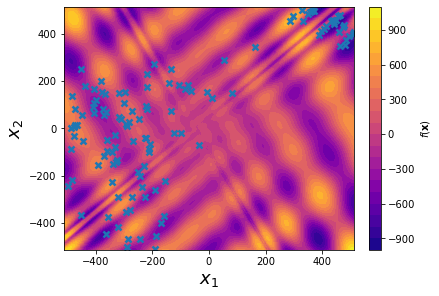

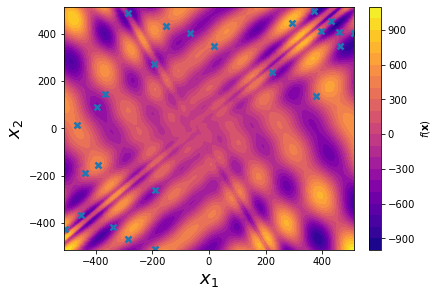

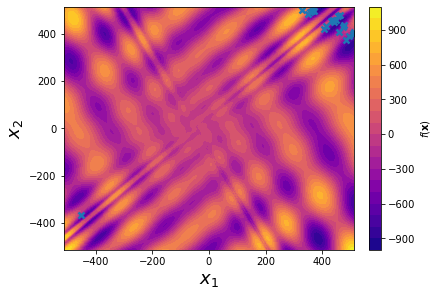

In [889]:
acc_hist = acc_hist == 1
best_hist = best_hist == 1 

f_plot = []
min = np.inf
for i in range(len(f_hist[acc_hist])):
    if f_hist[acc_hist][i] < min:
        min = f_hist[acc_hist][i]
        f_plot.append(min)
    else:
        f_plot.append(min)
plt.figure(figsize = (15,6))
plt.plot(T_hist, '-')
# plt.title('Objective Function f(x) for new solutions')
plt.ylabel('Temperature');plt.xlabel('Iteration number')
plt.yscale('log')
plt.show()

plt.figure(figsize = (15,6))
plt.plot(f_hist[best_hist], '-')
# plt.title('Objective Function f(x) for new solutions')
plt.ylabel('Objective Function value f(x)');plt.xlabel('Accpeted Solutions')
plt.show()

plt.figure(figsize = (15,6))
plt.plot(f_sol, '-')
# plt.title('Objective Function f(x) for new solutions')
plt.ylabel('Objective Function value f(x)');plt.xlabel('Accpeted Solutions')
plt.show()

plt.figure(figsize = (15,6))
plt.plot(f_hist[acc_hist], '-', color = 'C0', label = 'Cost')
plt.plot(f_plot, '-', color = 'C1',label = 'Current best cost')
plt.hlines(-959.6407,  0, len(f_hist[acc_hist]), linestyles = 'dashed', color = 'C1', label = 'Global minimum')
# plt.title('Objective Function f(x) for accepted iterations')
plt.ylabel('Objective Function value f(x)');plt.xlabel('Accpeted Iteration');plt.legend()
plt.show()


plot_walk(f_eval1, x_sol, num)
plot_points(f_eval1, x_hist[acc_hist], num,diss_archive_f)
plot_points(f_eval1, diss_archive_x, num,diss_archive_f)
plot_points(f_eval1, best_archive_x, num,best_archive_f)

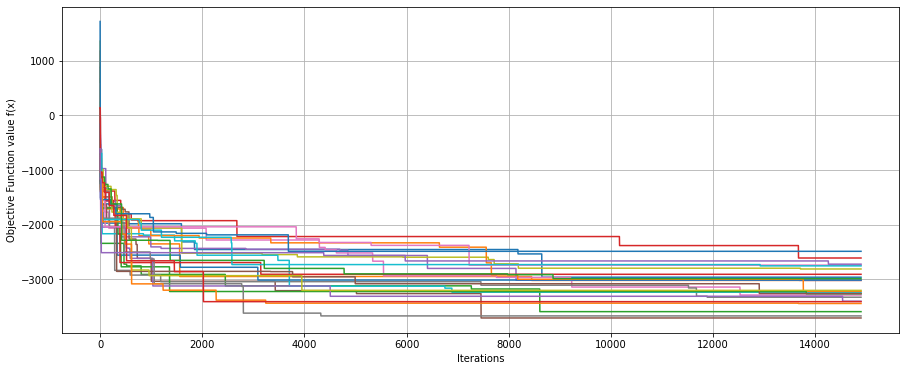

(-3119.4422377824226, 321.3091512353171, 1218.4137231252685)

In [926]:
DIM = 6
plt.figure(figsize = (15,6))
total = []
for j in range(25):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = j)
    acc_hist = acc_hist == 1
    best_hist = best_hist == 1 

    f_plot = []
    min = np.inf
    
    for i in range(len(f_hist)):
        if f_hist[i] < min:
            min = f_hist[i]
            f_plot.append(min)
        else:
            f_plot.append(min)
    total.append(min)
    plt.plot(f_plot, '-', color = 'C{}'.format(j), label = 'Seed = {}'.format(j))
plt.ylabel('Objective Function value f(x)');plt.xlabel('Iterations');plt.grid()
plt.show()
np.mean(total), np.std(total), np.max(total) - np.min(total)

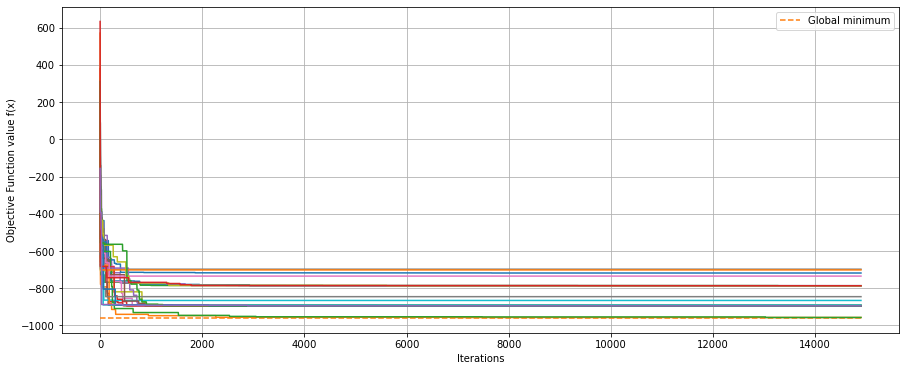

In [893]:
DIM = 2
plt.figure(figsize = (15,6))
for j in range(25):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = j)
    acc_hist = acc_hist == 1
    best_hist = best_hist == 1 

    f_plot = []
    min = np.inf
    for i in range(len(f_hist)):
        if f_hist[i] < min:
            min = f_hist[i]
            f_plot.append(min)
        else:
            f_plot.append(min)
    plt.plot(f_plot, '-', color = 'C{}'.format(j))
plt.ylabel('Objective Function value f(x)');plt.xlabel('Iterations')
plt.hlines(-959.6407,  0, len(f_hist), linestyles = 'dashed', color = 'C1', label = 'Global minimum')
plt.legend();plt.grid()
plt.show()

In [814]:
UPDATE_RULE = 'Simple'
ANNEALING_TYPE = 'Kirkpatrick'
DIM = 6
total = []
num = 25
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Kirkpatrick'
DIM = 6
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Parks: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Simple'
ANNEALING_TYPE = 'Huang'
DIM = 6
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
DIM = 6
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Parks: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

Simple: mean - -2716.735431056539, std - 212.74691040218266, highlow - 935.7643382657175
Parks: mean - -2797.010909621339, std - 270.3713394827403, highlow - 1061.469036372392
Simple: mean - -2692.780570721944, std - 277.55812733591614, highlow - 1119.6373322583422
Parks: mean - -2792.2277969489473, std - 187.88080498859432, highlow - 809.2988835894243


In [675]:
UPDATE_RULE = 'Simple'
ANNEALING_TYPE = 'Kirkpatrick'
DIM = 2
total = []
num = 20
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Kirkpatrick'
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Parks: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Simple'
ANNEALING_TYPE = 'Huang'
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Simple: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
total = []
for i in range(num):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
    total.append(f_best)
print('Parks: mean - {}, std - {}, highlow - {}'.format(np.mean(total),np.std(total), np.max(total)-np.min(total)))

Simple: mean - -943.3811601245437, std - 10.697122380672557, highlow - 35.23692108088153
Parks: mean - -947.9200721620093, std - 10.937157071957676, highlow - 40.268680294660044
Simple: mean - -909.7351343334701, std - 40.6584032287898, highlow - 150.81981514670906
Parks: mean - -911.7828051415121, std - 48.61042482802361, highlow - 169.98874916781165


In [627]:
num = 25
UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
DIM = 6
ds = np.linspace(0.1,2,10)
results = []
for d in ds:
    total = []
    D_INIT_MAG = d
    for i in range(num):
        x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
        total.append(f_best)
    results.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

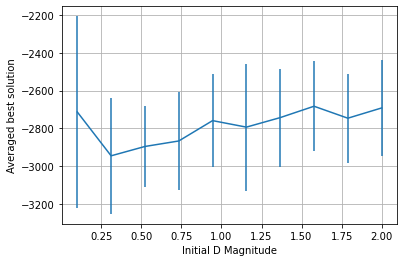

In [629]:
results = np.array(results)
plt.errorbar(ds, results[:,0], yerr=results[:,1])
plt.xlabel('Initial D Magnitude');plt.ylabel('Averaged best solution');plt.grid()
plt.show()


In [677]:
num = 25
UPDATE_RULE = 'Simple'
ANNEALING_TYPE = 'Huang'
DIM = 2
ds = np.linspace(0.1,2,10)
results2 = []
for d in ds:
    total = []
    D_INIT_MAG = d
    for i in range(num):
        x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, path, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
        total.append(f_best)
    results2.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

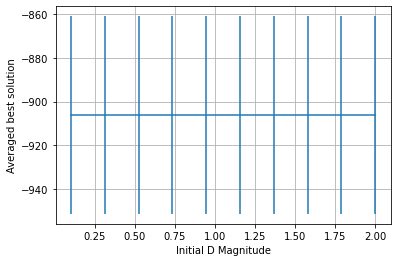

In [678]:
results2 = np.array(results2)
plt.errorbar(ds, results2[:,0], yerr=results2[:,1])
plt.xlabel('Initial D Magnitude');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [630]:
num = 25
UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
DIM = 6
D_INIT_MAG = ds[np.argmin(results[:,0])]
ls = np.linspace(50,500,10)
resultsl = []
for l in ls:
    total = []
    L_K = l
    for i in range(num):
        x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
        total.append(f_best)
    resultsl.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

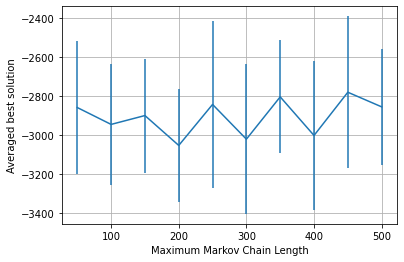

In [633]:
resultsl = np.array(resultsl)
plt.errorbar(ls, resultsl[:,0], yerr=resultsl[:,1])
plt.xlabel('Maximum Markov Chain Length');plt.ylabel('Averaged best solution');plt.grid()
plt.show()

In [809]:
num = 25
UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
DIM = 6
D_INIT_MAG = 0.32
L_K = 150
rs = np.linspace(25,400,15)
resultsr = []
for r in rs:
    total = []
    RESET_THRESHOLD = r
    for i in range(num):
        x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = i)
        total.append(f_best)
    resultsr.append([np.mean(total),np.std(total), np.max(total)-np.min(total)])

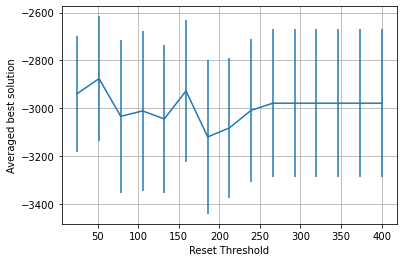

185.71428571428572

In [812]:
resultsr = np.array(resultsr)
plt.errorbar(rs, resultsr[:,0], yerr=resultsr[:,1])
plt.xlabel('Reset Threshold');plt.ylabel('Averaged best solution');plt.grid()
plt.show()
rs[np.argmin(resultsr[:,0])]

In [759]:
num = 25
UPDATE_RULE = 'Parks'
ANNEALING_TYPE = 'Huang'
DIM = 6
ds = np.linspace(0.1,2,10)
ls = np.linspace(50,500,10)
xx1, xx2 = np.meshgrid(ds,ls)
f_eval = np.zeros([len(xx1),len(xx2)])
results = []
for i in range(len(ds)):
    for j in range(len(ls)):
        D_INIT_MAG = ds[i]
        L_K = ls[j]
        total = []
        for k in range(20):
            x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = k)
            total.append(f_best)
        f_eval[i][j] = np.mean(total)

reset at 1258
reset at 1288
reset at 1260
reset at 1462
reset at 1104
reset at 1534
reset at 1424
reset at 1213
reset at 1541
reset at 1113
reset at 1087
reset at 1741
reset at 1209
reset at 1615
reset at 1090
reset at 1541
reset at 1181
reset at 1203
reset at 1160
reset at 1126
reset at 2098
reset at 1148
reset at 1605
reset at 1060
reset at 2013
reset at 1325
reset at 1402
reset at 1718
reset at 1233
reset at 1120
reset at 1390
reset at 1817
reset at 994
reset at 1112
reset at 1335
reset at 1883
reset at 1123
reset at 1340
reset at 1041
reset at 1231
reset at 1602
reset at 2079
reset at 1504
reset at 2069
reset at 1012
reset at 1423
reset at 1143
reset at 983
reset at 1384
reset at 1072
reset at 1271
reset at 1509
reset at 995
reset at 1041
reset at 1545
reset at 1059
reset at 943
reset at 1310
reset at 1049
reset at 1178
reset at 1324
reset at 1425
reset at 993
reset at 1037
reset at 1197
reset at 1165
reset at 963
reset at 1089
reset at 1041
reset at 1580
reset at 1224
reset at 993

Text(0, 0.5, '$f(\\mathbf{x})$')

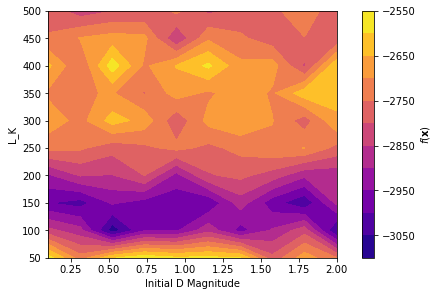

In [784]:
fig1, ax1 = plt.subplots(constrained_layout=True)
CS = ax1.contourf(xx1, xx2, f_eval, 10, cmap=cm.plasma)

ax1.set_xlabel('Initial D Magnitude')
ax1.set_ylabel('L_K')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$f(\mathbf{x})$')

In [766]:
min = np.inf
for i in range(10):
    for j in range(10):
        if f_eval[i][j] < min:
            min = f_eval[i][j]
            loc = [i,j]
loc

[1, 2]

In [767]:
ds[1], ls[2]

(0.3111111111111111, 150.0)

In [796]:
f_eval[1][2]

-3079.7879071436582

In [806]:
D_INIT_MAG = 0.32
L_K = 150
RESET_THRESHOLD = 100
total = []
for k in range(15):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = k)
    total.append(f_best)
np.mean(total), np.std(total)

(-2884.168349633784, 392.0109721081551)

In [799]:
D_INIT_MAG = 0.31
L_K = 150
RESET_THRESHOLD = 750
total = []
for k in range(25):
    x_best, f_best, x_hist, f_hist, T_hist, acc_hist, best_hist, best_archive_x, best_archive_f, diss_archive_x, diss_archive_f, x_sol, f_sol = search(seed = k)
    total.append(f_best)
np.mean(total), np.std(total)

(-2925.054836529731, 307.0188488407849)